In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("Biostrings")
install.packages('ape')
install.packages('seqinr')
install.packages('markovchain')
install.packages('emdist')
library(seqinr)
library(ape)
library(Biostrings)
library(markovchain)
library(transport)
library(emdist)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: http://cran.rstudio.com/

Bioconductor version 3.12 (BiocManager 1.30.20), R 4.0.5 (2021-03-31)

Installing package(s) 'Biostrings'

also installing the dependencies ‘zlibbioc’, ‘S4Vectors’, ‘IRanges’, ‘XVector’


Old packages: 'adabag', 'AICcmodavg', 'alphavantager', 'arrow', 'arules',
  'baguette', 'BART', 'batchtools', 'bayestestR', 'bestNormalize', 'bigrquery',
  'blob', 'bnlearn', 'brew', 'brms', 'broom', 'broom.helpers', 'bupaR',
  'butcher', 'cachem', 'caret', 'chatgpt', 'checkmate', 'chron', 'ckanr',
  'class', 'cli', 'clusterSim', 'collapse', 'commonmark', 'compositions',
  'confintr', 'contentid', 'correlation', 'covr', 'credentials', 'crosstable',
  'Cubist', 'datawizard', 'dbplyr', 'deaR', 'dendextend', 'densEstBayes',
  'DEoptimR', 'descr', 'deSolve', 'devEMF', 'dials', 'DIMORA', 'discrim',
  'distributional'

In [2]:
data=read.fasta('/kaggle/input/hev-sequence-data/HEV.txt',seqtype ="DNA")
set.seed(126)
sequences=sample(data,10)
minimum=min(unlist(lapply(sequences,function(x) length(x))));minimum
sequence_len = lapply(sequences,function(x) x[1:minimum])
sequence_dna=lapply(sequence_len, paste, collapse = "")
nchar(sequence_dna)        # for checking equal length
#lapply(sequences,function(x) table(x))
names(sequence_dna)


[1] 2104

4AB097812  4AB291968  3FJ906896 3bAB291953 3fEU723514  4AB220973  4AB074915 
      2104       2104       2104       2104       2104       2104       2104 
3bAB291955  1AF051351  4GU206559 
      2104       2104       2104

[1] "4AB097812"  "4AB291968"  "3FJ906896"  "3bAB291953" "3fEU723514"
 [6] "4AB220973"  "4AB074915"  "3bAB291955" "1AF051351"  "4GU206559"

In [46]:
library(Biostrings)
library(stringr)

# Load the genome sequence
for (j in 1:length(sequence_dna)) {
  genome <- DNAString(as.character(sequence_dna[j]))

  # Define the window size, CpG ratio threshold, and CpG observed/expected threshold for CpG island identification
  window_size <- 200
  cpg_ratio_threshold <- 0.6
  cpg_obs_exp_threshold <- 0.5

  # Calculate the CpG ratio and observed/expected values for each window
  cpg_ratio <- numeric(length(genome))
  cpg_obs_exp <- numeric(length(genome))
  for (i in window_size:length(genome)) {
    window <- genome[(i-window_size+1):i]
    cpg_count <- countPattern("CG",window)
    c_count <- countPattern("C",window)
    g_count <- countPattern("G",window)
    cpg_ratio[i] <- cpg_count / window_size
    cpg_obs_exp[i] <- cpg_count * c_count * g_count / (window_size^2)
  }

  # Identify the CpG islands based on the threshold values
  island_start <- 0
  island_end <- NULL
  for (i in window_size:length(genome)) {
    if (cpg_ratio[i] >= cpg_ratio_threshold && cpg_obs_exp[i] >= cpg_obs_exp_threshold) {
      if (island_start == 0) {
        island_start <- i
      }
    } else {
      if (island_start != 0) {
        island_end <- i - 1
        island_size <- island_end - island_start + 1
        cat("CpG island found at", island_start, "-", island_end, "with size", island_size, "\n")
        island_start <- 0
        island_end <- NULL
      }
    }
  }
}

### Q.7. CpG Island

In [61]:
library(Biostrings)
library(stringr)

# Load the genome sequence
genome<-NULL
for (j in 1:length(sequence_dna)) {
  genome <- DNAString(as.character(sequence_dna[j]))
 # print(paste("Length of genome:", length(genome)))

  # Define the window size, CpG ratio threshold, and CpG observed/expected threshold for CpG island identification
  window_size <- 200
  cpg_ratio_threshold <- 0.1
  cpg_obs_exp_threshold <- 0.2

  # Calculate the CpG ratio and observed/expected values for each window
  cpg_ratio <- numeric(length(genome))
  cpg_obs_exp <- numeric(length(genome))
  for (i in window_size:length(genome)) {
    window <- genome[(i-window_size+1):i]
    cpg_count <- countPattern("CG",window)
    c_count <- countPattern("C",window)
    g_count <- countPattern("G",window)
    cpg_ratio[i] <- cpg_count / window_size
    cpg_obs_exp[i] <- cpg_count * c_count * g_count / (window_size^2)
    #print(paste("Window:", i, "CpG ratio:", cpg_ratio[i], "CpG obs/exp:", cpg_obs_exp[i]))
  }

  # Identify the CpG islands based on the threshold values
  island_start <- 0
  island_end <- NULL
  for (i in window_size:length(genome)) {
    if (cpg_ratio[i] >= cpg_ratio_threshold && cpg_obs_exp[i] >= cpg_obs_exp_threshold) {
      if (island_start == 0) {
        island_start <- i
      }
    } else {
      if (island_start != 0) {
        island_end <- i - 1
        island_size <- island_end - island_start + 1
        cat("CpG island found at", island_start, "-", island_end, "with size", island_size,"for the sequence: ",names(sequence_dna[j]), "\n")
        island_start <- 0
        island_end <- NULL
      }
    }
  }
}

CpG island found at 396 - 396 with size 1 for the sequence:  4AB097812 
CpG island found at 398 - 477 with size 80 for the sequence:  4AB097812 
CpG island found at 479 - 515 with size 37 for the sequence:  4AB097812 
CpG island found at 932 - 934 with size 3 for the sequence:  3FJ906896 
CpG island found at 1791 - 1834 with size 44 for the sequence:  3bAB291953 
CpG island found at 408 - 413 with size 6 for the sequence:  4AB074915 
CpG island found at 416 - 454 with size 39 for the sequence:  4AB074915 
CpG island found at 475 - 478 with size 4 for the sequence:  4AB074915 
CpG island found at 486 - 486 with size 1 for the sequence:  4AB074915 
CpG island found at 526 - 599 with size 74 for the sequence:  4AB074915 
CpG island found at 1791 - 1834 with size 44 for the sequence:  3bAB291955 
CpG island found at 233 - 434 with size 202 for the sequence:  1AF051351 
CpG island found at 443 - 605 with size 163 for the sequence:  1AF051351 
CpG island found at 607 - 615 with size 9 for th

In [8]:
# Entropy for each sequence
S=sequence_len
n=length(S[[1]])
A=c();G=c();C=c();T=c()
 p=c()
 H=c()
 for(i in 1:10)
 {
 A[i]=length(subset(S[[i]],S[[i]]=="a"))
 G[i]=length(subset(S[[i]],S[[i]]=="g"))
 C[i]=length(subset(S[[i]],S[[i]]=="c"))
 T[i]=length(subset(S[[i]],S[[i]]=="t"))
 p[[i]]=c(A[i]/n,G[i]/n,C[i]/n,T[i]/n)
 H[i]=sum((-p[[i]])*log2(p[[i]]))
 }
H


[1] 1.978418 1.977849 1.976367 1.981666 1.979782 1.978883 1.977593 1.981648
 [9] 1.963407 1.979906

In [57]:
aa=seq(1,length(sequence_len[[1]]),by=floor(length(sequence_len[[1]])*0.1));
mid=aa[5:6]
S=sequence_len
#last_10=floor(length(sequence_len[[1]])*0.9);last_10
#last=length(sequence_len[[1]])-last_10
# Mutual Information for each sequence
 library(infotheo)
m=matrix(nrow=10,ncol=(mid[2]-mid[1]+1))
for(i in 1:10)
 {
 m[i,]=S[[i]][mid[1]:mid[2]]
 }
 MIC1=matrix(nrow=10,ncol=10)
 for(i in 1:10)
 {
 for(j in 1:10)
 {

 MIC1[i,j]=mutinformation(m[i,],m[j,])
 }
 }
MIC1

1.36035460,1.08328229,0.02415146,0.044535255,0.67314381,1.12557820,0.019563587,0.044535255,0.02358522,0.870499024
1.08328229,1.35365665,0.03313750,0.030899968,0.69742743,1.30969958,0.012108146,0.030899968,0.02134743,0.915990669
0.02415146,0.03313750,1.36098549,0.020384230,0.02201911,0.03487477,0.031327998,0.020384230,0.01306289,0.029771983
0.04453525,0.03089997,0.02038423,1.348968812,0.03907729,0.03492659,0.008021858,1.348968812,0.01258196,0.033051791
0.67314381,0.69742743,0.02201911,0.039077290,1.34449483,0.71659889,0.015497851,0.039077290,0.01551235,0.713017294
1.12557820,1.30969958,0.03487477,0.034926585,0.71659889,1.35881845,0.013721046,0.034926585,0.02126705,0.954430210
0.01956359,0.01210815,0.03132800,0.008021858,0.01549785,0.01372105,1.350478460,0.008021858,0.01519845,0.009111619
0.04453525,0.03089997,0.02038423,1.348968812,0.03907729,0.03492659,0.008021858,1.348968812,0.01258196,0.033051791
0.02358522,0.02134743,0.01306289,0.012581957,0.01551235,0.02126705,0.015198448,0.012581957,1.37113005,0.016059307
0.87049902,0.91599067,0.02977198,0.033051791,0.71301729,0.95443021,0.009111619,0.033051791,0.01605931,1.353659475


In [3]:
#aa=seq(1,length(sequence_len[[1]]),by=floor(length(sequence_len[[1]])*0.1));
#mid=aa[5:6]
S=sequence_len
#last_10=floor(length(sequence_len[[1]])*0.9);last_10
#last=length(sequence_len[[1]])-last_10
# Mutual Information for each sequence
library(infotheo)
m=matrix(nrow=10,ncol=(length(S[[1]])))
for(i in 1:10)
 {
 m[i,]=S[[i]]#[mid[1]:mid[2]]
 }
 MIC1=matrix(nrow=10,ncol=10)
 for(i in 1:10)
 {
 for(j in 1:10)
 {

 MIC1[i,j]=mutinformation(m[i,],m[j,])
 }
 }
MIC1

1.371334721,0.989467916,0.007653479,0.004333823,0.526403839,0.999167776,0.002253650,0.004544496,0.003958231,0.861897652
0.989467916,1.370940730,0.007197695,0.003157297,0.539453589,1.262465064,0.001492807,0.003469335,0.003134577,0.856539430
0.007653479,0.007197695,1.369913229,0.001808690,0.007123265,0.007375099,0.002812794,0.001818268,0.001931557,0.008576110
0.004333823,0.003157297,0.001808690,1.373586269,0.003244796,0.003305043,0.002130515,1.342571695,0.001514066,0.004477738
0.526403839,0.539453589,0.007123265,0.003244796,1.372280614,0.536396240,0.002471962,0.003492345,0.003989630,0.522554969
0.999167776,1.262465064,0.007375099,0.003305043,0.536396240,1.371656945,0.001364355,0.003631629,0.002811507,0.864657874
0.002253650,0.001492807,0.002812794,0.002130515,0.002471962,0.001364355,1.370762840,0.001658846,0.001540050,0.002159864
0.004544496,0.003469335,0.001818268,1.342571695,0.003492345,0.003631629,0.001658846,1.373573739,0.001718748,0.004769033
0.003958231,0.003134577,0.001931557,0.001514066,0.003989630,0.002811507,0.001540050,0.001718748,1.360930288,0.003426022
0.861897652,0.856539430,0.008576110,0.004477738,0.522554969,0.864657874,0.002159864,0.004769033,0.003426022,1.372366322


In [9]:
d1=matrix(0,nrow=10,ncol=10)
for(i in 1:10)
 {
 for(j in 1:10)
 {
 d1[i,j]=abs(H[i]-H[j])

 }
 }
 round (d1,6)

0.000000,0.000568,0.002051,0.003248,0.001365,0.000465,0.000825,0.003230,0.015010,0.001488
0.000568,0.000000,0.001482,0.003817,0.001933,0.001033,0.000257,0.003799,0.014442,0.002057
0.002051,0.001482,0.000000,0.005299,0.003415,0.002516,0.001226,0.005281,0.012960,0.003539
0.003248,0.003817,0.005299,0.000000,0.001884,0.002783,0.004073,0.000018,0.018259,0.001760
0.001365,0.001933,0.003415,0.001884,0.000000,0.000900,0.002190,0.001866,0.016375,0.000124
0.000465,0.001033,0.002516,0.002783,0.000900,0.000000,0.001290,0.002765,0.015475,0.001023
0.000825,0.000257,0.001226,0.004073,0.002190,0.001290,0.000000,0.004055,0.014185,0.002313
0.003230,0.003799,0.005281,0.000018,0.001866,0.002765,0.004055,0.000000,0.018241,0.001742
0.015010,0.014442,0.012960,0.018259,0.016375,0.015475,0.014185,0.018241,0.000000,0.016499
0.001488,0.002057,0.003539,0.001760,0.000124,0.001023,0.002313,0.001742,0.016499,0.000000


In [ ]:
# Define a function to compute the Manhattan distance
manhattan_distance <- function(seq1, seq2) {
  # Convert the sequences to uppercase to ensure consistency
  seq1 <- toupper(seq1)
  seq2 <- toupper(seq2)
  
  # Compute the length of the sequences
  len1 <- nchar(seq1)
  len2 <- nchar(seq2)
  
  # Check if the sequences have the same length
  if (len1 != len2) {
    stop("Sequences have different lengths")
  }
  
  # Compute the Manhattan distance
  distance <- sum(abs(as.integer(charToRaw(seq1)) - as.integer(charToRaw(seq2))))
  
  # Return the distance
  return(distance)
}

# Compute the Manhattan distance between the two sequences
distance <- manhattan_distance(sequence1, sequence2)

# Print the distance
print(distance)

manhattan_distance_matrix <- function(sequences) {
  # Compute the number of sequences
  n <- length(sequences)
  
  # Initialize the distance matrix with zeros
  distance_matrix <- matrix(0, nrow = n, ncol = n)
  
  # Compute the Manhattan distance between each pair of sequences
  for (i in 1:(n-1)) {
    for (j in (i+1):n) {
      distance <- manhattan_distance(sequences[i], sequences[j])
      distance_matrix[i,j] <- distance
      distance_matrix[j,i] <- distance
    }
  }
  
  # Return the distance matrix
  return(distance_matrix)
}
kk=manhattan_distance_matrix(sequence_dna);kk

In [15]:
#install.packages("CCA")
install.packages('phangorn')
library(ape)
tree=upgma(d1,method="average")
row.names(d1)=c("I1","I2","I3","I4","I5","I6","I7","I8","I9","B1")
branch_name1 = round(branching.times(tree),5)
branch_name1
plot(tree,main="UPGMA tree using distance function as difference between entropy",type
= "phylogram",adj = 0.5,edge.width =2,edge.color=1:10)
nodelabels(tree$node.label,cex=0.6,frame = "circle")
axisPhylo(side = 1,root.time = TRUE)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘hdrcde’, ‘rainbow’, ‘fds’, ‘fda’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘phangorn’ is not available for this version of R
‘phangorn’ version 2.11.1 is in the repositories but depends on R (>= 4.1.0)

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


ERROR: Error in upgma(d1, method = "average"): could not find function "upgma"


## MI based Distance
##### Explain how do you use mutual information content to obtain tree topology in case of DNA sequences. Using your suggested algorithm obtain the tree topology for your data

In the case of DNA sequences, mutual information can be used to determine the similarity between different sequences, which can in turn be used to construct a tree topology that reflects the evolutionary relationships between those sequences.

To obtain the tree topology for a set of DNA sequences, one would first need to calculate the pairwise mutual information between all pairs of sequences. This can be done using a variety of methods, such as calculating the mutual information between individual nucleotides or between whole sequences.

Once the mutual information values have been calculated, the neighbor-joining algorithm can be used to construct the tree topology. In this case, the distance between two sequences can be defined as the negative of their mutual information. The algorithm then proceeds as follows:

1. Initialize a distance matrix based on the mutual information values.
2. Find the pair of sequences with the smallest distance and group them together.
3. Compute the distances between the new group and all the remaining sequences, and update the distance matrix accordingly.
4. Repeat steps 2 and 3 until all sequences have been grouped together into a single cluster.
5. Use the resulting clustering to construct the tree topology.

In [4]:
#aa=seq(1,length(sequence_len[[1]]),by=floor(length(sequence_len[[1]])*0.1));
#mid=aa[5:6]
S=sequence_len
#last_10=floor(length(sequence_len[[1]])*0.9);last_10
#last=length(sequence_len[[1]])-last_10
# Mutual Information for each sequence
library(infotheo)
m=matrix(nrow=10,ncol=(length(S[[1]])))
for(i in 1:10)
 {
 m[i,]=S[[i]]#[mid[1]:mid[2]]
 }
 MIC1=matrix(nrow=10,ncol=10)
 for(i in 1:10)
 {
 for(j in 1:10)
 {

 MIC1[i,j]=mutinformation(m[i,],m[j,])
 }
 }
MIC1


1.371334721,0.989467916,0.007653479,0.004333823,0.526403839,0.999167776,0.002253650,0.004544496,0.003958231,0.861897652
0.989467916,1.370940730,0.007197695,0.003157297,0.539453589,1.262465064,0.001492807,0.003469335,0.003134577,0.856539430
0.007653479,0.007197695,1.369913229,0.001808690,0.007123265,0.007375099,0.002812794,0.001818268,0.001931557,0.008576110
0.004333823,0.003157297,0.001808690,1.373586269,0.003244796,0.003305043,0.002130515,1.342571695,0.001514066,0.004477738
0.526403839,0.539453589,0.007123265,0.003244796,1.372280614,0.536396240,0.002471962,0.003492345,0.003989630,0.522554969
0.999167776,1.262465064,0.007375099,0.003305043,0.536396240,1.371656945,0.001364355,0.003631629,0.002811507,0.864657874
0.002253650,0.001492807,0.002812794,0.002130515,0.002471962,0.001364355,1.370762840,0.001658846,0.001540050,0.002159864
0.004544496,0.003469335,0.001818268,1.342571695,0.003492345,0.003631629,0.001658846,1.373573739,0.001718748,0.004769033
0.003958231,0.003134577,0.001931557,0.001514066,0.003989630,0.002811507,0.001540050,0.001718748,1.360930288,0.003426022
0.861897652,0.856539430,0.008576110,0.004477738,0.522554969,0.864657874,0.002159864,0.004769033,0.003426022,1.372366322


11       12       13       14       15       16       17       18 
 0.07761 -0.01825 -0.15875 -0.15751 -2.08667 -2.40268 -2.58031 -5.64568

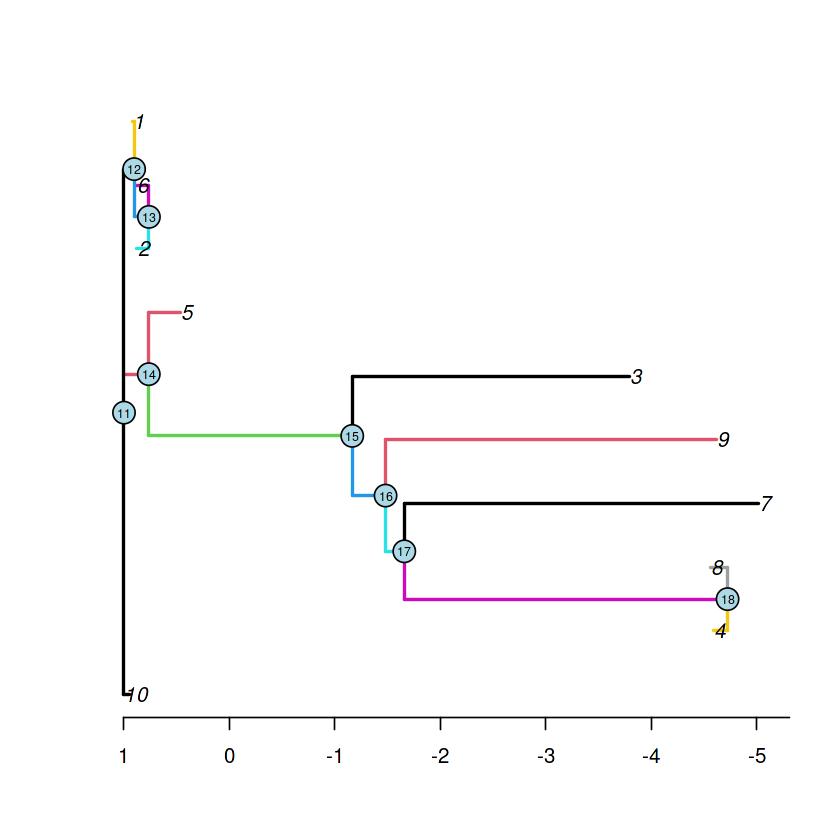

In [5]:
dist_matrix_MI <- -log(MIC1)
dist_list <- as.dist(dist_matrix_MI)

# Perform NJ clustering
tree <- nj(dist_list)

# Plot the resulting tree
branch_name = round(branching.times(tree),5)
branch_name
plot(tree,type = "phylogram",adj = 0.5,edge.width = 2,edge.color = 1:10)
nodelabels(tree$node.label,cex=0.6,frame = "circle")
axisPhylo(side = 1,root.time = TRUE)


# Q.6

In [27]:
# Q.6  TPM and Ergodicity
tpm=list()
irr=c()
ergodic= matrix(0,nrow=10,ncol=2)
for( i in 1:length(sequences))
    {
    tpm[[i]]=markovchainFit(data=sequences[[i]])$estimate
    irr[i]=is.irreducible(tpm[[i]])
    ergodic[i,]=c(irr[i],period(tpm[[i]]))
}
tpm
apply(ergodic,1,sum)

[[1]]
MLE Fit 
 A  4 - dimensional discrete Markov Chain defined by the following states: 
 a, c, g, t 
 The transition matrix  (by rows)  is defined as follows: 
          a         c         g         t
a 0.1814759 0.2951807 0.2537651 0.2695783
c 0.2000000 0.3092637 0.2118765 0.2788599
g 0.1869060 0.3152059 0.2629356 0.2349525
t 0.1621762 0.2409326 0.3170984 0.2797927


[[2]]
MLE Fit 
 A  4 - dimensional discrete Markov Chain defined by the following states: 
 a, c, g, t 
 The transition matrix  (by rows)  is defined as follows: 
          a         c         g         t
a 0.1894502 0.2971768 0.2414562 0.2719168
c 0.1997133 0.3076923 0.2068801 0.2857143
g 0.1880661 0.3122003 0.2647842 0.2349494
t 0.1656347 0.2389061 0.3204334 0.2750258


[[3]]
MLE Fit 
 A  4 - dimensional discrete Markov Chain defined by the following states: 
 a, c, g, t 
 The transition matrix  (by rows)  is defined as follows: 
          a         c         g         t
a 0.2000000 0.2822222 0.2488889 0.2688889
c 0

[1] 2 2 2 2 2 2 2 2 2 2

In [ ]:
## # Q.2. (C)

In [16]:

cosine_distance <- function(seqs) {
  
  # Check that the input sequences are character strings
  if (!all(sapply(seqs, is.character))) {
    stop("Input sequences must be character strings")
  }
  
  # Check that the input sequences have the same length
  if (!all(sapply(seqs, function(s) nchar(s) == nchar(seqs[[1]])))) {
    stop("Input sequences must have the same length")
  }
  
  # Check that the input sequences only contain A, C, G, and T
  nucleotides <- c("a", "c", "g", "t")
  if (!all(sapply(seqs, function(s) all(unique(strsplit(s, "")[[1]]) %in% nucleotides)))) {
    stop("Input sequences can only contain a, c, g, and t")
  }
  
  # Count the number of occurrences of each nucleotide for each sequence
  freq_matrix <- matrix(0, nrow = length(seqs), ncol = length(nucleotides))
  for (i in 1:length(seqs)) {
    freq_matrix[i,] <- table(strsplit(seqs[[i]], "")[[1]])
  }
  
  # Convert the counts to frequencies and normalize the vectors
  freq_norm <- t(apply(freq_matrix, 1, function(x) x / sqrt(sum(x^2))))
  
  # Calculate the pairwise Cosine distances between the normalized vectors
  dist_matrix <- matrix(0, nrow = length(seqs), ncol = length(seqs))
  for (i in 1:(length(seqs) - 1)) {
    for (j in (i + 1):length(seqs)) {
      cosine_sim <- sum(freq_norm[i,] * freq_norm[j,])
      dist_matrix[i, j] <- 1-cosine_sim
      dist_matrix[j, i] <- 1-cosine_sim
    }
  }
  
  return(dist_matrix)
}

seq=list("acgcta","tcgtca")                       
# Example usage
dist_matrix_cosine <- cosine_distance(sequence_dna)
print(dist_matrix_cosine)

              [,1]         [,2]         [,3]         [,4]         [,5]
 [1,] 0.000000e+00 6.050663e-04 1.123824e-04 3.529138e-04 4.607049e-04
 [2,] 6.050663e-04 0.000000e+00 2.796335e-04 1.733202e-03 5.107425e-05
 [3,] 1.123824e-04 2.796335e-04 0.000000e+00 8.582416e-04 2.326659e-04
 [4,] 3.529138e-04 1.733202e-03 8.582416e-04 0.000000e+00 1.385392e-03
 [5,] 4.607049e-04 5.107425e-05 2.326659e-04 1.385392e-03 0.000000e+00
 [6,] 4.298701e-04 2.084257e-05 1.948319e-04 1.390720e-03 1.655648e-05
 [7,] 2.685873e-04 8.164363e-05 6.382899e-05 1.171498e-03 6.070842e-05
 [8,] 3.300350e-04 1.674238e-03 8.239681e-04 8.825008e-07 1.337799e-03
 [9,] 5.677203e-03 2.773163e-03 4.376765e-03 8.643355e-03 3.479348e-03
[10,] 1.542626e-05 6.433175e-04 1.759052e-04 2.753167e-04 4.595141e-04
              [,6]         [,7]         [,8]        [,9]        [,10]
 [1,] 4.298701e-04 2.685873e-04 3.300350e-04 0.005677203 1.542626e-05
 [2,] 2.084257e-05 8.164363e-05 1.674238e-03 0.002773163 6.433175e-04
 [3,] 1.9

11       12       13       14       15       16       17       18 
 0.00007 -0.00009 -0.00030 -0.00061 -0.00101 -0.00126 -0.00185 -0.00035

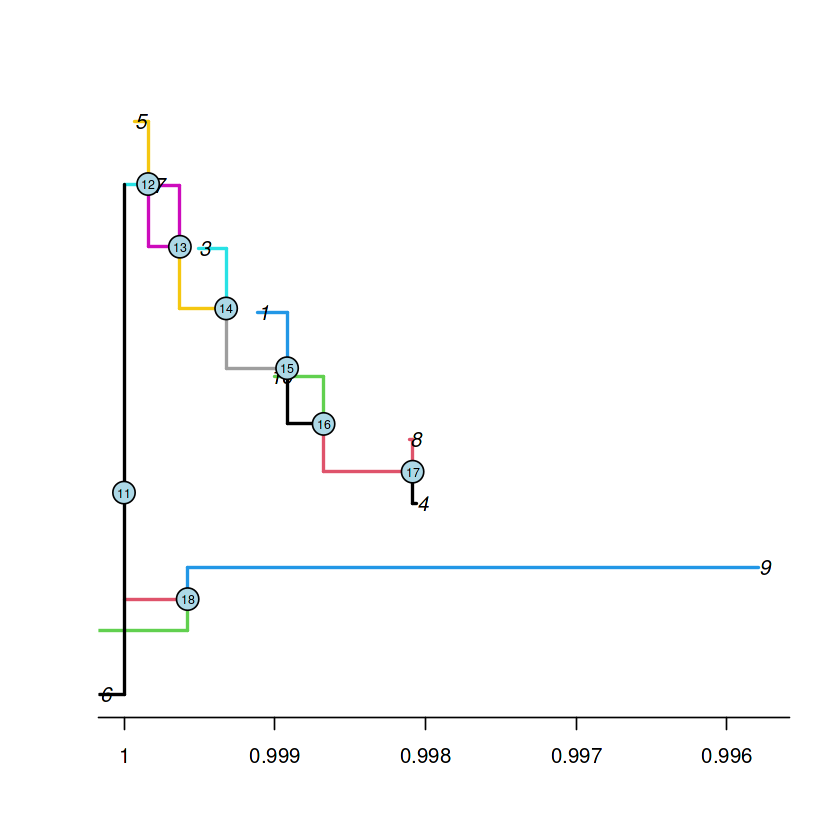

In [12]:
# Generate a distance matrix for DNA sequences
# Convert distance matrix to a list format for NJ
dist_list <- as.dist(dist_matrix_cosine)

# Perform NJ clustering
tree <- nj(dist_list)

# Plot the resulting tree
branch_name = round(branching.times(tree),5)
branch_name
plot(tree,type = "phylogram",adj = 0.5,edge.width = 2,edge.color = 1:10)
nodelabels(tree$node.label,cex=0.6,frame = "circle")
axisPhylo(side = 1,root.time = TRUE)


## Q.4

In [9]:
n=length(sequence_dna)
# Create an empty matrix to store the Hamming distances
hamming_matrix <- matrix(0, n, n)

# Calculate Hamming distance matrix
for (i in 1:(n-1)) {
  for (j in (i+1):n) {
    seq1 <- strsplit(sequence_dna[[i]], "")[[1]]
    seq2 <- strsplit(sequence_dna[[j]], "")[[1]]
    hamming_dist <- sum(seq1 != seq2)
    hamming_matrix[i,j] <- hamming_dist
    hamming_matrix[j,i] <- hamming_dist
  }
}

# Print Hamming distance matrix
hamming_matrix

0,238,1592,1604,558,234,1580,1602,1518,315
238,0,1583,1587,546,47,1582,1585,1521,330
1592,1583,0,1539,1578,1590,1581,1536,1598,1585
1604,1587,1539,0,1588,1587,1569,10,1554,1594
558,546,1578,1588,0,548,1600,1588,1503,561
234,47,1590,1587,548,0,1581,1585,1522,324
1580,1582,1581,1569,1600,1581,0,1570,1579,1595
1602,1585,1536,10,1588,1585,1570,0,1551,1592
1518,1521,1598,1554,1503,1522,1579,1551,0,1517
315,330,1585,1594,561,324,1595,1592,1517,0


11        12        13        14        15        16        17        18 
806.50000 790.36719 749.60938 266.32812 146.18750 105.11250  11.98750  50.27344

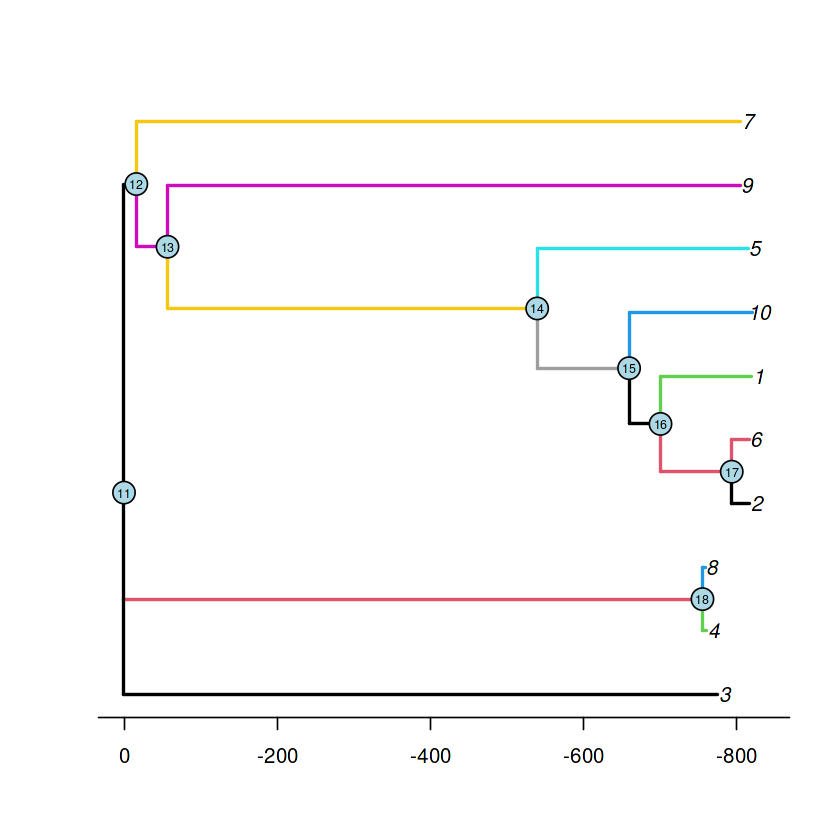

In [10]:
# Generate a distance matrix for DNA sequences
# Convert distance matrix to a list format for NJ
dist_list <- as.dist(hamming_matrix)

# Perform NJ clustering
tree <- nj(dist_list)

# Plot the resulting tree
branch_name = round(branching.times(tree),5)
branch_name
plot(tree,type = "phylogram",adj = 0.5,edge.width = 2,edge.color = 1:10)
nodelabels(tree$node.label,cex=0.6,frame = "circle")
axisPhylo(side = 1,root.time = TRUE)

In [14]:
euclidean_distance <- function(seqs) {
  n <- length(seqs)
  distance_matrix <- matrix(0, nrow = n, ncol = n)
  
  # Calculate the nucleotide frequencies at each position
  freq_matrix <- matrix(0, nrow = n, ncol = nchar(seqs[[1]]))
  for (i in 1:n) {
    seq <- seqs[[i]]
    for (j in 1:nchar(seq)) {
      nucleotide <- substr(seq, j, j)
      freq_matrix[i, j] <- sum(strsplit(seq, "")[[1]] == nucleotide) / n
    }
  }
  
  # Calculate the Euclidean distance between each pair of sequences
  for (i in 1:(n - 1)) {
    for (j in (i + 1):n) {
      distance <- sqrt(sum((freq_matrix[i,] - freq_matrix[j,])^2))
      distance_matrix[i, j] <- distance
      distance_matrix[j, i] <- distance
    }
  }
  
  return(distance_matrix)
}



euclid_dist_matrix <- euclidean_distance(sequence_dna)
print(euclid_dist_matrix)



          [,1]      [,2]     [,3]      [,4]     [,5]      [,6]     [,7]
 [1,]   0.0000 183.25883 533.5790 500.70131 306.4992 169.13379 522.8980
 [2,] 183.2588   0.00000 548.4691 516.34169 311.5105  73.77425 539.3561
 [3,] 533.5790 548.46909   0.0000 505.75148 531.5650 541.66501 533.6285
 [4,] 500.7013 516.34169 505.7515   0.00000 497.1360 509.34368 501.1917
 [5,] 306.4992 311.51051 531.5650 497.13602   0.0000 307.42505 528.4933
 [6,] 169.1338  73.77425 541.6650 509.34368 307.4250   0.00000 529.7269
 [7,] 522.8980 539.35606 533.6285 501.19166 528.4933 529.72695   0.0000
 [8,] 500.3497 516.06939 505.2526  35.31544 497.6574 509.07223 501.1623
 [9,] 639.0891 654.72219 666.0921 634.36089 641.9085 649.58170 662.1963
[10,] 198.3436 218.07999 522.8738 490.24343 304.7726 209.12929 516.4160
           [,8]     [,9]    [,10]
 [1,] 500.34974 639.0891 198.3436
 [2,] 516.06939 654.7222 218.0800
 [3,] 505.25255 666.0921 522.8738
 [4,]  35.31544 634.3609 490.2434
 [5,] 497.65743 641.9085 304.7726
 [6,

11        12        13        14        15        16        17        18 
264.65172 264.41810 255.92299 156.15858 106.63915  86.15392  29.39246  45.81229

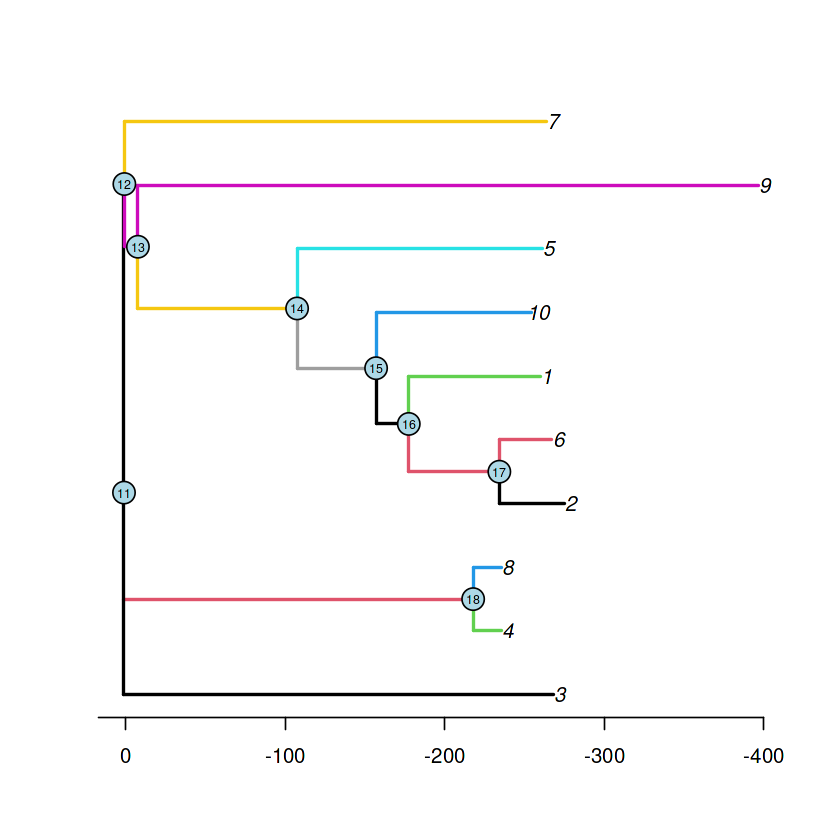

In [21]:
# Generate a distance matrix for DNA sequences
# Convert distance matrix to a list format for NJ
dist_list <- as.dist(euclid_dist_matrix)

# Perform NJ clustering
tree <- nj(dist_list)

# Plot the resulting tree
branch_name = round(branching.times(tree),5)
branch_name
plot(tree,type = "phylogram",adj = 0.5,edge.width = 2,edge.color = 1:10)
nodelabels(tree$node.label,cex=0.6,frame = "circle")
axisPhylo(side = 1,root.time = TRUE)

In [21]:
minkowski_distance <- function(seqs,p) {
  n <- length(seqs)
  distance_matrix <- matrix(0, nrow = n, ncol = n)
  
  # Calculate the nucleotide frequencies at each position
  freq_matrix <- matrix(0, nrow = n, ncol = nchar(seqs[[1]]))
  for (i in 1:n) {
    seq <- seqs[[i]]
    for (j in 1:nchar(seq)) {
      nucleotide <- substr(seq, j, j)
      freq_matrix[i, j] <- sum(strsplit(seq, "")[[1]] == nucleotide) / n
    }
  }
  
  # Calculate the Euclidean distance between each pair of sequences
  for (i in 1:(n - 1)) {
    for (j in (i + 1):n) {
      distance <- sqrt(sum((freq_matrix[i,] - freq_matrix[j,])^p))
      distance_matrix[i, j] <- distance
      distance_matrix[j, i] <- distance
    }
  }
  
  return(distance_matrix)
}



minkowski_dist_matrix <- minkowski_distance(sequence_dna,p=4)
minkowski_dist_matrix


0.000,2881.804,11029.024,9717.9450,5898.234,2715.728,10569.247,9715.7277,14561.70,3654.089
2881.804,0.000,11392.890,10043.6194,6176.232,1074.699,10948.581,10043.8513,15084.86,3491.319
11029.024,11392.890,0.000,9995.9774,10790.500,11112.959,10937.181,9989.0395,15666.94,10601.293
9717.945,10043.619,9995.977,0.0000,9431.942,9830.696,9828.883,616.0287,14135.38,9361.757
5898.234,6176.232,10790.500,9431.9420,0.000,6033.398,10468.094,9450.6908,14407.57,5712.984
2715.728,1074.699,11112.959,9830.6957,6033.398,0.000,10610.945,9830.9028,14866.59,3395.059
10569.247,10948.581,10937.181,9828.8832,10468.094,10610.945,0.000,9823.7568,15380.93,10261.787
9715.728,10043.851,9989.040,616.0287,9450.691,9830.903,9823.757,0.0000,14139.86,9359.757
14561.698,15084.855,15666.940,14135.3814,14407.569,14866.591,15380.931,14139.8605,0.00,14414.539
3654.089,3491.319,10601.293,9361.7572,5712.984,3395.059,10261.787,9359.7572,14414.54,0.000


11        12        13        14        15        16        17        18 
4441.2855 4325.6256 4072.9724 2146.6252  940.1514  359.0743 -591.6718  308.4759

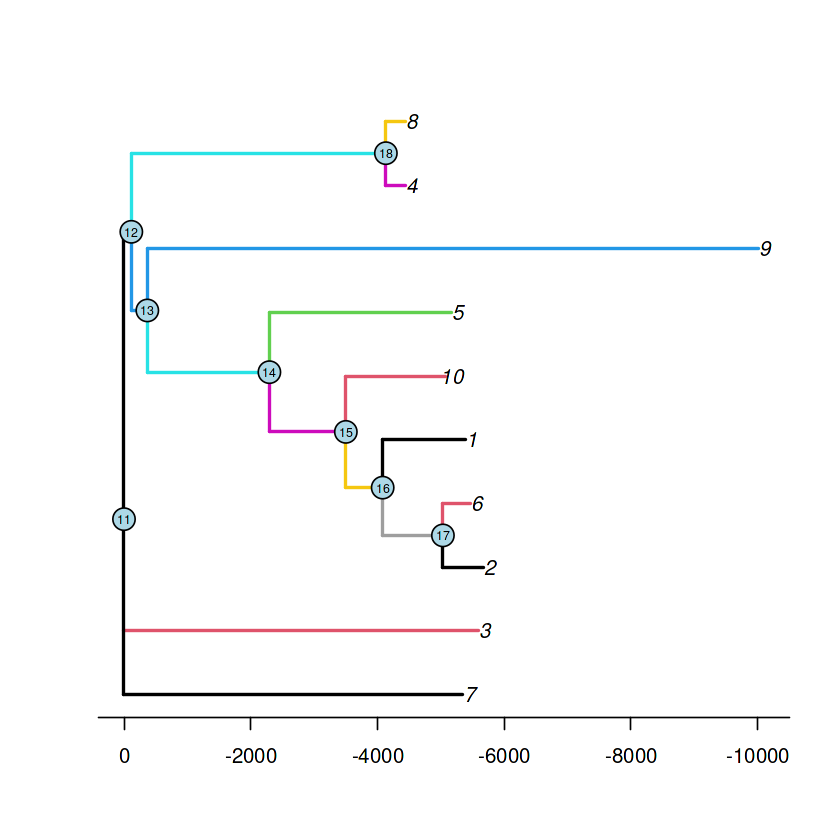

In [22]:
# Generate a distance matrix for DNA sequences
# Convert distance matrix to a list format for NJ
dist_list <- as.dist(minkowski_dist_matrix)

# Perform NJ clustering
tree <- nj(dist_list)

# Plot the resulting tree
branch_name = round(branching.times(tree),5)
branch_name
plot(tree,type = "phylogram",adj = 0.5,edge.width = 2,edge.color = 1:10)
nodelabels(tree$node.label,cex=0.6,frame = "circle")
axisPhylo(side = 1,root.time = TRUE)

In [17]:
  # Define function to check ultrametric condition
is_ultrametric <- function(matrix) {
  matrix=as.matrix(matrix)
  n <- nrow(matrix)
  for (i in 1:(n-2)) {
    for (j in (i+1):(n-1)) {
      for (k in (j+1):n) {
        d_ij <- matrix[i,j]
        d_ik <- matrix[i,k]
        d_jk <- matrix[j,k]
        if (((d_ij == d_ik && d_ij < d_jk) ||
              (d_ij == d_jk && d_ij < d_ik) ||
              (d_ik == d_jk && d_ik < d_ij))||
              ((d_ik!=d_jk)&& (d_jk!=d_ij) && (d_ik!=d_ij)))
        
        {
          return(FALSE)
        }
      }
    }
  }
  return(TRUE)
}
is_ultrametric(minkowski_dist_matrix)
is_ultrametric(euclid_dist_matrix)
is_ultrametric(hamming_matrix)
is_ultrametric(dist_matrix_cosine)
is_ultrametric(EMD_dist)

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

In [18]:
is_ultrametric <- function(matrix) {
    matrix=as.matrix(matrix)
  n <- nrow(matrix)
  for (i in 1:(n-2)) {
    for (j in (i+1):(n-1)) {
      for (k in (j+1):n) {
        d_ij <- matrix[i,j]
        d_ik <- matrix[i,k]
        d_jk <- matrix[j,k]
        if (d_ij > max(d_ik, d_jk)) {
          return(FALSE)
        }
      }
    }
  }
  return(TRUE)
}

# Check ultrametric condition for distance matrix

is_ultrametric(minkowski_dist_matrix)
is_ultrametric(euclid_dist_matrix)
is_ultrametric(hamming_matrix)
is_ultrametric(dist_matrix_cosine)
is_ultrametric(EMD_dist)

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

In [20]:
# Define Function to check for Four-point condition
is_four_point <- function(matrix) {
    matrix=as.matrix(matrix)
  n <- nrow(matrix)
  for (i in 1:(n-3)) {
    for (j in (i+1):(n-2)) {
      for (m in (j+1):(n-1)) {
        for (n in (m+1):n) {
          if (matrix[i,j] + matrix[m,n] > max(matrix[i,m] + matrix[j,n], matrix[i,n] + matrix[j,m])) {
            return(FALSE)
          }
        }
      }
    }
  }
  return(TRUE)
}

# Check four-point condition for distance matrix
if (is_four_point(matrix)) {
  print("The distance matrix satisfies the four-point condition.")
} else {
  print("The distance matrix does not satisfy the four-point condition.")
}

is_four_point(minkowski_dist_matrix)
is_four_point(euclid_dist_matrix)
is_four_point(hamming_matrix)
is_four_point(dist_matrix_cosine)
is_four_point(EMD_dist)

ERROR: Error in as.vector(x, mode): cannot coerce type 'closure' to vector of type 'any'


In [55]:
# Define function to check four-point condition
is_four_point <- function(matrix) {
matrix=as.matrix(matrix) 
  n <- nrow(matrix)
  for (i in 1:(n-3)) {
    for (j in (i+1):(n-2)) {
      for (k in (j+1):(n-1)) {
        for (l in (k+1):n) {
          d_ij <- matrix[i,j]
          d_kl <- matrix[k,l]
          d_ik <- matrix[i,k]
          d_jl <- matrix[j,l]
          d_il <- matrix[i,l]
          d_jk <- matrix[j,k]
          if ((d_ij + d_kl) > max(d_ik + d_jl, d_il + d_jk)) {
            return(FALSE)
          }
        }
      }
    }
  }
  return(TRUE)
}
is_four_point(minkowski_dist_matrix)
is_four_point(euclid_dist_matrix)
is_four_point(hamming_matrix)
is_four_point(dist_matrix_cosine)
is_four_point(EMD_dist)

[1] FALSE

[1] FALSE

[1] FALSE

[1] FALSE

## Q.5.

In [64]:
chebyshev_matrix=dist_new
n=9
d_star=matrix(0,nrow=n,ncol=n)
r=apply(chebyshev_matrix,1,sum)/(n-2)
for( i in 1:(n-1))
    {
    for( j in (i+1): n)
        {
        d_star[i,j]= chebyshev_matrix[i,j]-(r[i]+r[j])
        d_star[j,i]=d_star[i,j]
    }
}
d_star


0.00000,-35.71429,-48.00000,-39.42857,-38.57143,-41.14286,-35.71429,-62.28571,-64.00000
-35.71429,0.00000,-44.28571,-51.71429,-52.85714,-49.42857,-62.00000,-34.57143,-34.28571
-48.00000,-44.28571,0.00000,-42.00000,-44.14286,-48.71429,-44.28571,-46.85714,-46.57143
-39.42857,-51.71429,-42.00000,0.00000,-52.57143,-47.14286,-51.71429,-40.28571,-40.00000
-38.57143,-52.85714,-44.14286,-52.57143,0.00000,-49.28571,-52.85714,-37.42857,-37.14286
-41.14286,-49.42857,-48.71429,-47.14286,-49.28571,0.00000,-49.42857,-40.00000,-39.71429
-35.71429,-62.00000,-44.28571,-51.71429,-52.85714,-49.42857,0.00000,-34.57143,-34.28571
-62.28571,-34.57143,-46.85714,-40.28571,-37.42857,-40.00000,-34.57143,0.00000,-68.85714
-64.00000,-34.28571,-46.57143,-40.00000,-37.14286,-39.71429,-34.28571,-68.85714,0.00000


In [62]:
#r=apply(chebyshev_matrix,1,sum)/(8)
n=10
val=which.min(d_star);val
index=c(ceiling(val/n),val%%n)
{
if(val%%n==0)
    {
# We combine 4th seq with the 8th seq
# distance of these combine point say, a with others is
d_st4a= 0.5*(chebyshev_matrix[index[1],n]+r[index[1]]-r[n])
    print(d_st4a)
d_st8a= 0.5*(chebyshev_matrix[index[1],n]+r[n]-r[index[1]])
    print(d_st8a)
index=c(ceiling(val/n),n)

}
else
{
d_st4a= 0.5*(chebyshev_matrix[index[1],index[2]]+r[index[1]]-r[index[2]]);
    print(d_st4a)
d_st8a= 0.5*(chebyshev_matrix[index[1],index[2]]+r[index[2]]-r[index[1]]);
    print(d_st8a)
}
    }
index

[1] 38

[1] 1
[1] 0


[1] 4 8

In [63]:
n=10
dist_new= matrix(0,nrow=n-1,ncol=n-1)
ind=c(1:n)
ind=ind[-c(index[1],index[2])];ind
count=1

for( i in 1:(n-1))
    {
    if(i!=(n-1))
        {
        dist_new[c(1:(n-2)),c(1:(n-2))]= chebyshev_matrix[-c(index[1],index[2]),-c(index[1],index[2])]
    }
        else 
            {
            for(j in ind) 
                {
    dist_new[count,i]= 0.5*(chebyshev_matrix[j,index[1]]+chebyshev_matrix[j,index[2]]-(chebyshev_matrix[index[1],index[2]]))
    dist_new[i,count]=dist_new[count,i]
                count=count+1
    }
    }
    }
dist_new



[1]  1  2  3  5  6  7  9 10

0,28,13,22,22,19,97,5,23
28,0,15,8,6,9,69,31,51
13,15,0,15,12,7,84,16,36
22,8,15,0,4,9,77,23,43
22,6,12,4,0,6,75,25,45
19,9,7,9,6,0,78,22,42
97,69,84,77,75,78,0,100,120
5,31,16,23,25,22,100,0,20
23,51,36,43,45,42,120,20,0


In [4]:
chebyshev_dist=function(seq_list)
    {
# Convert the sequences to frequency tables
freq_list <- lapply(seq_list, function(x) table(strsplit(x, "")[[1]]))

# Calculate the Chebyshev distance matrix
n_seqs <- length(seq_list)
chebyshev_matrix <- matrix(0, ncol = n_seqs, nrow = n_seqs)
for (i in 1:(n_seqs - 1)) {
  for (j in (i + 1):n_seqs) {
    chebyshev_matrix[i, j] <- max(abs(freq_list[[i]] - freq_list[[j]]))
    chebyshev_matrix[j, i] <- chebyshev_matrix[i, j]
  }
}
                    return(chebyshev_matrix)
}
                    chebyshev_matrix=chebyshev_dist(sequence_dna);chebyshev_matrix
                   
                    dist_new=chebyshev_matrix

0,28,13,24,22,22,19,23,97,5
28,0,15,52,8,6,9,51,69,31
13,15,0,37,15,12,7,36,84,16
24,52,37,0,44,46,43,1,121,21
22,8,15,44,0,4,9,43,77,23
22,6,12,46,4,0,6,45,75,25
19,9,7,43,9,6,0,42,78,22
23,51,36,1,43,45,42,0,120,20
97,69,84,121,77,75,78,120,0,100
5,31,16,21,23,25,22,20,100,0


11       12       13       14       15       16       17       18 
74.00000 73.87500 70.00000 69.00000 64.58333 53.18333 49.85000 29.99286

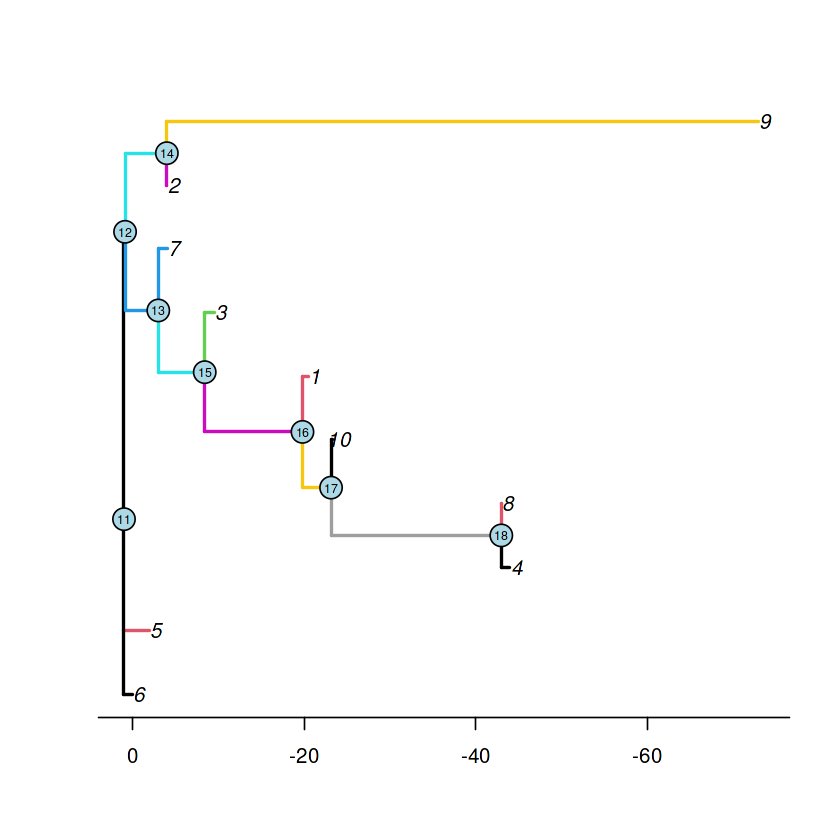

In [5]:
dist_list <- as.dist(chebyshev_matrix)

# Perform NJ clustering
tree <- nj(dist_list)

# Plot the resulting tree
branch_name = round(branching.times(tree),5)
branch_name
plot(tree,type = "phylogram",adj = 0.5,edge.width = 2,edge.color = 1:10)
nodelabels(tree$node.label,cex=0.6,frame = "circle")
axisPhylo(side = 1,root.time = TRUE)

In [7]:
D_star=list()
D_mat=list()
comb_index=list()
comb_val=list()
R=list()
for( n in 10:2)
    {
chebyshev_matrix=dist_new

d_star=matrix(0,nrow=n,ncol=n)
r=apply(chebyshev_matrix,1,sum)/(n-2)
R[[n]]=r
for( i in 1:(n-1))
    {
    for( j in (i+1): n)
        {
        d_star[i,j]= chebyshev_matrix[i,j]-(r[i]+r[j])
        d_star[j,i]=d_star[i,j]
    }
}
D_star[[n]]=d_star
#chebyshev_matrix=dist_new
#n=9
#r=apply(chebyshev_matrix,1,sum)/(8)
#n=10
val=which.min(d_star);val
index=c(ceiling(val/n),val%%n)
{
if(val%%n==0)
    {
# We combine 4th seq with the 8th seq
# distance of these combine point say, a with others is
d_st4a= 0.5*(chebyshev_matrix[index[1],n]+r[index[1]]-r[n])
    #print(d_st4a)
d_st8a= 0.5*(chebyshev_matrix[index[1],n]+r[n]-r[index[1]])
    #print(d_st8a)
index=c(ceiling(val/n),n)

}
else
{
d_st4a= 0.5*(chebyshev_matrix[index[1],index[2]]+r[index[1]]-r[index[2]]);
    #print(d_st4a)
d_st8a= 0.5*(chebyshev_matrix[index[1],index[2]]+r[index[2]]-r[index[1]]);
    #print(d_st8a)
}
    }
comb_index[[n]]= index
comb_val[[n]]=c(d_st4a,d_st8a)
#n=10
dist_new= matrix(0,nrow=n-1,ncol=n-1)
ind=c(1:n)
ind=ind[-c(index[1],index[2])];ind
count=1

for( i in 1:(n-1))
    {
    if(i!=(n-1))
        {
        dist_new[c(1:(n-2)),c(1:(n-2))]= chebyshev_matrix[-c(index[1],index[2]),-c(index[1],index[2])]
    }
        else 
            {
            for(j in ind) 
                {
    dist_new[count,i]= 0.5*(chebyshev_matrix[j,index[1]]+chebyshev_matrix[j,index[2]]-(chebyshev_matrix[index[1],index[2]]))
    dist_new[i,count]=dist_new[count,i]
                count=count+1
    }
    }
    }
D_mat[[n]]=dist_new
    }

In [8]:
R

[[1]]
NULL

[[2]]
[1] Inf Inf

[[3]]
[1] 13.75 12.75  9.00

[[4]]
[1]  9.500  7.500 11.375 10.375

[[5]]
[1] 10.833333  8.833333 10.166667 14.500000 12.666667

[[6]]
[1] 26.750 27.375 25.375 27.125 95.750 31.875

[[7]]
[1] 26.9 29.1 26.7 24.9 25.5 95.9 39.4

[[8]]
[1] 34.16667 27.66667 27.00000 26.33333 25.00000 25.00000 96.66667 36.83333

[[9]]
[1]  32.71429  31.00000  28.28571  28.71429  27.85714  27.42857 100.00000
[8]  34.57143  54.28571

[[10]]
 [1]  31.625  33.625  29.375  48.625  30.625  30.125  29.375  47.625 102.625
[10]  32.875

In [9]:
comb_index

[[1]]
NULL

[[2]]
[1] 1 2

[[3]]
[1] 1 2

[[4]]
[1] 1 2

[[5]]
[1] 3 4

[[6]]
[1] 1 5

[[7]]
[1] 2 7

[[8]]
[1] 1 8

[[9]]
[1] 8 9

[[10]]
[1] 4 8

In [10]:
comb_val

[[1]]
NULL

[[2]]
[1] NaN NaN

[[3]]
[1] 4.875 3.875

[[4]]
[1] 3 1

[[5]]
[1] 1.083333 5.416667

[[6]]
[1]  0 69

[[7]]
[1]  1.1 11.4

[[8]]
[1] 0.6666667 3.3333333

[[9]]
[1]  0.1428571 19.8571429

[[10]]
[1] 1 0

In [11]:
D_mat

[[1]]
NULL

[[2]]
     [,1]
[1,]    0

[[3]]
      [,1]  [,2]
[1,] 0.000 0.125
[2,] 0.125 0.000

[[4]]
     [,1] [,2] [,3]
[1,] 0.00 8.75    5
[2,] 8.75 0.00    4
[3,] 5.00 4.00    0

[[5]]
     [,1] [,2] [,3] [,4]
[1,]    0    4 8.00 7.00
[2,]    4    0 6.00 5.00
[3,]    8    6 0.00 8.75
[4,]    7    5 8.75 0.00

[[6]]
     [,1] [,2] [,3] [,4] [,5]
[1,]  0.0  4.0  9.0 11.5    8
[2,]  4.0  0.0  6.0 10.5    6
[3,]  9.0  6.0  0.0  6.5    9
[4,] 11.5 10.5  6.5  0.0   15
[5,]  8.0  6.0  9.0 15.0    0

[[7]]
     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0  8.0  6.0  9.0   69 15.0
[2,]    8  0.0  4.0  9.0   77 11.5
[3,]    6  4.0  0.0  6.0   75 10.5
[4,]    9  9.0  6.0  0.0   78  6.5
[5,]   69 77.0 75.0 78.0    0 84.0
[6,]   15 11.5 10.5  6.5   84  0.0

[[8]]
     [,1] [,2] [,3] [,4] [,5] [,6] [,7]
[1,]  0.0 15.0  8.0  6.0  9.0 69.0 27.5
[2,] 15.0  0.0 15.0 12.0  7.0 84.0 12.5
[3,]  8.0 15.0  0.0  4.0  9.0 77.0 20.5
[4,]  6.0 12.0  4.0  0.0  6.0 75.0 21.5
[5,]  9.0  7.0  9.0  6.0  0.0 78.0 18.5
[6,] 69.0 84.0 77.0 75.0 78.0  0.0 96.5
[7,] 27.5 12.5 20.5 21.5 18.5 96.5  0.0

[[9]]
     [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8]
[1,]    0   28   13   22   22   19   97    4
[2,]   28    0   15    8    6    9   69   31
[3,]   13   15    0   15   12    7   84   16
[4,]   22    8   15    0    4    9   77   23
[5,]   22    6   12    4    0    6   75   25
[6,]   19    9    7    9    6    0   78   22
[7,]   97   69   84   77   75   78    0  100
[8,]    4   31   16   23   25   22  100    0

[[10]]
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9]
 [1,]    0   28   13   22   22   19   97    5   23
 [2,]   28    0   15    8    6    9   69   31   51
 [3,]   13   15    0   15   12    7   84   16   36
 [4,]   22    8   15    0    4    9   77   23   43
 [5,]   22    6   12    4    0    6   75   25   45
 [6,]   19    9    7    9    6    0   78   22   42
 [7,]   97   69   84   77   75   78    0  100  120
 [8,]    5   31   16   23   25   22  100    0   20
 [9,]   23   51   36   43   45   42  120   20    0

In [58]:
n=10
D=chebyshev_matrix
D_mat=list()
D_star=list()
#ind_coll=c()
index_count=1
index=list()
combin_point_dist=list()
for( k in n:2)
    {
     r=apply(D,1,sum)/(k-2)
    d_star=matrix(0,nrow=k,ncol=k)
for(i in 1:(k-1))
    {
    for( j in (i+1): k)
        {
        d_star[i,j]= D[i,j]-(r[i]+r[j])
        d_star[j,i]=d_star[i,j]
    }
}
D_star[[index_count]]=d_star
val=which.min(d_star)
index[[index_count]]=c(ceiling(val/k),val%%k)
    {
if(val%%k==0)
    {
# We combine 4th seq with the 8th seq
# distance of these combine point say, a with others is
combin_point_dist[[index_count]]= 
c(0.5*(D[index[[index_count]][1],k]+r[index[[index_count]][1]]-r[k]), 0.5*(D[index[[index_count]][1],k]+r[k]-r[index[[index_count]][1]]))
index[[index_count]]=c(ceiling(val/k),k)

}
else
{
combin_point_dist[[index_count]]= 
c(0.5*(D[index[[index_count]][1],index[[index_count]][2]]+r[index[[index_count]][1]]-r[index[[index_count]][2]]), 0.5*(D[index[[index_count]][1],index[[index_count]][2]]+r[index[[index_count]][2]]-r[index[[index_count]][1]]))}
    }
#ind_coll=c(ind_coll,indexindex[[index_count]])
combin_point_dist[[index_count]]= 
c(0.5*(D[index[[index_count]][1],index[[index_count]][2]]+r[index[[index_count]][1]]-r[index[[index_count]][2]]), 0.5*(D[index[[index_count]][1],index[[index_count]][2]]+r[index[[index_count]][2]]-r[index[[index_count]][1]]))
dist_new= matrix(0,nrow=n-(index_count),ncol=n-(index_count))
ind=c(1:k)    
ind=ind[-c(index[[index_count]][1],index[[index_count]][2])]
dis_count=1

for( i in 1:(n-1))
    {
    if(i!=(n-1))
        {
        dist_new[c(1:(n-(index_count+1))),c(1:(n-(index_count+1)))]= D[-c(index[[index_count]][1],index[[index_count]][2]),-c(index[[index_count]][1],index[[index_count]][2])]
    }
        else 
            {
            for(j in ind) 
                {
    dist_new[dis_count,i]= 0.5*(D[j,index[[index_count]][1]]+D[j,index[[index_count]][2]]-(D[index[[index_count]][1],index[[index_count]][2]]))
    dist_new[i,dis_count]=dist_new[dis_count,i]
                dis_count=dis_count+1
    }
    }
    }
                                    D=dist_new
                                    D_mat[[index_count]]=D
                                    index_count=index_count+1
                                    
}

ERROR: Error in `[<-`(`*tmp*`, dis_count, i, value = 0.5 * (D[j, index[[index_count]][1]] + : subscript out of bounds


In [33]:
n <- 10
D <- matrix(runif(n * n), nrow = n) # Create a random Chebyshev distance matrix as an example
D_mat <- list()
D_star <- list()
index_count <- 1
ind <- 1:10
index <- list()
combin_point_dist <- list()

for (k in seq(n, 2, by = -1)) {
  r <- apply(D, 1, sum) / (k - 2)
  d_star <- matrix(0, nrow = k, ncol = k)
  
  for (i in 1:(k - 1)) {
    for (j in (i + 1):k) {
      d_star[i, j] <- D[i, j] - (r[i] + r[j])
      d_star[j, i] <- d_star[i, j]
    }
  }
  
  D_star[[index_count]] <- d_star
  val <- which.min(d_star)
  idx <- c(ceiling(val / k), val %% k)
  
  if (val %% k == 0) {
    idx <- c(ceiling(val / k), k)
  }
  
  index[[index_count]] <- idx
  combin_point_dist[[index_count]] <- c(
    0.5 * (D[idx[1], idx[2]] + r[idx[1]] - r[idx[2]]),
    0.5 * (D[idx[1], idx[2]] + r[idx[2]] - r[idx[1]])
  )
  
  dist_new <- matrix(0, nrow = n - index_count, ncol = n - index_count)
  ind <- ind[-c(idx[1], idx[2])]
  dis_count <- 1
  
  for (i in 1:(n - 1)) {
    if (i != (n - 1)) {
      dist_new[1:(n - (index_count + 1)), 1:(n - (index_count + 1))] <- D[-c(idx[1], idx[2]), -c(idx[1], idx[2])]
    } else {
      for (j in ind) {
        dist_new[dis_count, i] <- 0.5 * (D[j, idx[1]] + D[j, idx[2]] - D[idx[1], idx[2]])
        dist_new[i, dis_count] <- dist_new[dis_count, i]
        dis_count <- dis_count + 1
      }
    }
  }

  D <- dist_new
  D_mat[[index_count]] <- D
  index_count <- index_count + 1
}

ERROR: Error in `[<-`(`*tmp*`, dis_count, i, value = 0.5 * (D[j, idx[1]] + D[j, : subscript out of bounds


In [44]:
D_mat

0,28,13,22,22,19,97,5,23
28,0,15,8,6,9,69,31,51
13,15,0,15,12,7,84,16,36
22,8,15,0,4,9,77,23,43
22,6,12,4,0,6,75,25,45
19,9,7,9,6,0,78,22,42
97,69,84,77,75,78,0,100,120
5,31,16,23,25,22,100,0,20
23,51,36,43,45,42,120,20,0


In [35]:
D=chebyshev_matrix;D
D=dist_new;D

0,28,13,24,22,22,19,23,97,5
28,0,15,52,8,6,9,51,69,31
13,15,0,37,15,12,7,36,84,16
24,52,37,0,44,46,43,1,121,21
22,8,15,44,0,4,9,43,77,23
22,6,12,46,4,0,6,45,75,25
19,9,7,43,9,6,0,42,78,22
23,51,36,1,43,45,42,0,120,20
97,69,84,121,77,75,78,120,0,100
5,31,16,21,23,25,22,20,100,0


0,28,13,22,22,19,97,5,23
28,0,15,8,6,9,69,31,51
13,15,0,15,12,7,84,16,36
22,8,15,0,4,9,77,23,43
22,6,12,4,0,6,75,25,45
19,9,7,9,6,0,78,22,42
97,69,84,77,75,78,0,100,120
5,31,16,23,25,22,100,0,20
23,51,36,43,45,42,120,20,0


In [13]:
(chebyshev_matrix[index[1],index[2]])

[1] 1

0,28,13,22,22,19,97,5,0
28,0,15,8,6,9,69,31,0
13,15,0,15,12,7,84,16,0
22,8,15,0,4,9,77,23,0
22,6,12,4,0,6,75,25,0
19,9,7,9,6,0,78,22,0
97,69,84,77,75,78,0,100,0
5,31,16,23,25,22,100,0,0


In [19]:
chebyshev_matrix

0,28,13,24,22,22,19,23,97,5
28,0,15,52,8,6,9,51,69,31
13,15,0,37,15,12,7,36,84,16
24,52,37,0,44,46,43,1,121,21
22,8,15,44,0,4,9,43,77,23
22,6,12,46,4,0,6,45,75,25
19,9,7,43,9,6,0,42,78,22
23,51,36,1,43,45,42,0,120,20
97,69,84,121,77,75,78,120,0,100
5,31,16,21,23,25,22,20,100,0


In [17]:

print_dist_mat <- function(D) {
print(D)
}
neighbor_joining <- function(D) {
n <- nrow(D)
if (n == 2) {
tree <- list(edge = matrix(c(1,2), nrow = 1), label = c(1,2))
return(tree)
}
Q <- calc_Q(D, n)
delta <- (sum(rowSums(D)) - sum(diag(D))) / (n - 3)
for (i in 1:n) {
for (j in 1:n) {
if (i != j) {
Q[i,j] <- Q[i,j] - (sum(D[i,]) - delta) - (sum(D[j,]) - delta)
}
}
}
min_el <- find_min(Q)
i <- min_el$i
j <- min_el$j

print_dist_mat(D)

r <- 0.5*D[i,j] + 0.5*(sum(D[i,]) - sum(D[j,]))/(n-3)

#Check dimensions of sub-matrices
if (length(D[i,]) != n - 2 || length(D[j,]) != n - 2) {
stop("Invalid dimensions for rows in D")
}
if (length(q_i[-i]) != (n - 3) || length(q_j[-j]) != (n - 3)) {
stop("Invalid dimensions for sub-matrices")
}

q_i <- (D[i,] - D[j,])/2 + r
q_j <- (D[j,] - D[i,])/2 + r
D_new <- matrix(0, n-2, n-2)
D_new[1:(i-1),1:(i-1)] <- D[1:(i-1),1:(i-1)]
D_new[(i+2):(n-2),(i+2):(n-2)] <- D[(i+2):n,(i+2):n]
D_new[1:(i-1),(i+2):(n-2)] <- q_i[-c(i,j)]
D_new[(i+2):(n-2),1:(i-1)] <- t(q_i[-c(i,j)])
D_new[1:(j-1),1:(j-1)] <- D_new[1:(j-1),1:(j-1)] + q_j[-c(i,j)]
D_new[(j+2):(n-2),(j+2):(n-2)] <- D_new[(j+2):(n-2),(j+2):(n-2)] + q_j[-c(i,j)]
D_new[1:(j-1),(j+2):(n-2)] <- D_new[1:(j-1),(j+2):(n-2)] + t(q_j[-c(i,j)])
D_new[(j+2):(n-2),1:(j-1)] <- D_new[(j+2):(n-2),1:(j-1)] + t(q_j[-c(i,j)])

#Check dimensions of D_new
if (dim(D_new) != c(n - 2, n - 2)) {
stop("Invalid dimensions for D_new")
}

tree_i <- neighbor_joining(D_new)
tree_i$edge <- cbind(tree_i$edge, rbind(i, j, n))
tree_j <- neighbor_joining(D_new)
tree_j$edge <- cbind(tree_j$edge, rbind(j, i, n))
tree <- list(edge = rbind(tree_i$edge, tree_j$edge), label = c(tree_i$label, tree_j$label))
return(tree)
}
neighbor_joining(chebyshev_matrix)

      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10]
 [1,]    0   28   13   24   22   22   19   23   97     5
 [2,]   28    0   15   52    8    6    9   51   69    31
 [3,]   13   15    0   37   15   12    7   36   84    16
 [4,]   24   52   37    0   44   46   43    1  121    21
 [5,]   22    8   15   44    0    4    9   43   77    23
 [6,]   22    6   12   46    4    0    6   45   75    25
 [7,]   19    9    7   43    9    6    0   42   78    22
 [8,]   23   51   36    1   43   45   42    0  120    20
 [9,]   97   69   84  121   77   75   78  120    0   100
[10,]    5   31   16   21   23   25   22   20  100     0


ERROR: Error in neighbor_joining(chebyshev_matrix): Invalid dimensions for rows in D


11       12       13       14       15       16       17       18 
74.00000 73.87500 70.00000 69.00000 64.58333 53.18333 49.85000 29.99286

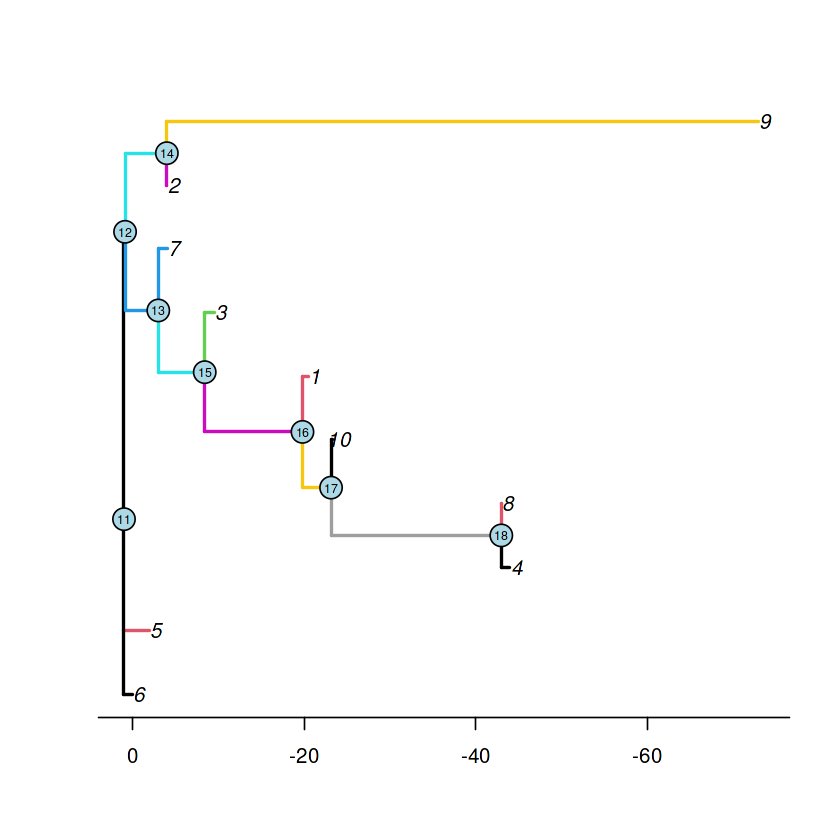

In [104]:
# Generate a distance matrix for DNA sequences
# Convert distance matrix to a list format for NJ
dist_list <- as.dist(chebyshev_matrix)

# Perform NJ clustering
tree <- nj(dist_list)

# Plot the resulting tree
branch_name = round(branching.times(tree),5)
branch_name
plot(tree,type = "phylogram",adj = 0.5,edge.width = 2,edge.color = 1:10)
nodelabels(tree$node.label,cex=0.6,frame = "circle")
axisPhylo(side = 1,root.time = TRUE)

In [23]:

EMD=function(seq_list)
    {
# Convert the sequences to frequency tables
freq_list <- lapply(seq_list, function(x) table(strsplit(x, "")[[1]]))

# Convert frequency tables to EMD format
emd_list <- lapply(freq_list, function(x) {
  idx <- seq_along(x)
  data.frame(weight = as.numeric(x), location = idx)
})

# Calculate the Earth Mover's Distance matrix
n_seqs <- length(seq_list)
emd_matrix <- matrix(0, ncol = n_seqs, nrow = n_seqs)
for (i in 1:(n_seqs - 1)) {
  for (j in (i + 1):n_seqs) {
    mat_i <- as.matrix(emd_list[[i]])
    mat_j <- as.matrix(emd_list[[j]])
    emd_matrix[i, j] <- emdist::emdr(mat_i, mat_j, distance = "euclidean", method = "transport")
    emd_matrix[j, i] <- emd_matrix[i, j]
  }
}
         return(emd_matrix)         
                    }
EMD_dist=EMD(sequence_dna);EMD_dist

0.000000000,0.027566539,0.009980989,0.0166349802,0.029467681,0.025665399,0.017110266,0.0161596965,0.06463879,0.003802281
0.027566539,0.000000000,0.022338403,0.0394486710,0.004752852,0.003802281,0.010456273,0.0389733836,0.04182509,0.023764258
0.009980989,0.022338403,0.000000000,0.0266159698,0.024239544,0.020437263,0.011882129,0.0261406843,0.05465779,0.010931559
0.016634980,0.039448671,0.026615970,0.0000000000,0.036596958,0.035646386,0.032794677,0.0004752852,0.08127376,0.015684411
0.029467681,0.004752852,0.024239544,0.0365969576,0.000000000,0.003802281,0.012357415,0.0361216739,0.04467681,0.025665399
0.025665399,0.003802281,0.020437263,0.0356463864,0.003802281,0.000000000,0.008555133,0.0351711027,0.04562738,0.021863118
0.017110266,0.010456273,0.011882129,0.0327946767,0.012357415,0.008555133,0.000000000,0.0323193930,0.04847909,0.017110266
0.016159697,0.038973384,0.026140684,0.0004752852,0.036121674,0.035171103,0.032319393,0.0000000000,0.08079848,0.015209125
0.064638786,0.041825093,0.054657795,0.0812737644,0.044676807,0.045627378,0.048479088,0.0807984769,0.00000000,0.065589353
0.003802281,0.023764258,0.010931559,0.0156844109,0.025665399,0.021863118,0.017110266,0.0152091254,0.06558935,0.000000000


11       12       13       14       15       16       17       18 
 0.00229  0.00136  0.00034 -0.00428 -0.01242 -0.01896 -0.01955 -0.03381

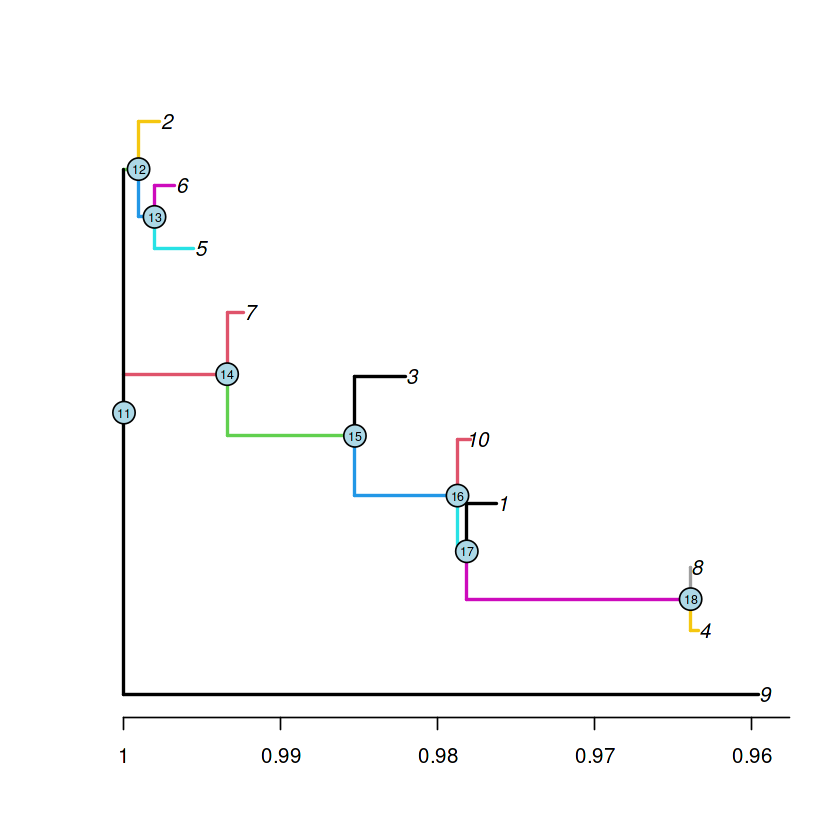

In [24]:
# Generate a distance matrix for DNA sequences
# Convert distance matrix to a list format for NJ
dist_list <- as.dist(EMD_dist)

# Perform NJ clustering
tree <- nj(dist_list)

# Plot the resulting tree
branch_name = round(branching.times(tree),5)
branch_name
plot(tree,type = "phylogram",adj = 0.5,edge.width = 2,edge.color = 1:10)
nodelabels(tree$node.label,cex=0.6,frame = "circle")
axisPhylo(side = 1,root.time = TRUE)